# Chapter 14 
 Machine Learning for Business Analytics<br>
Concepts, Techniques, and Applications in Python<br>
by Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel

Publisher: Wiley; 2nd edition (2024) <br>
<!-- ISBN-13: 978-3031075650 -->

(c) 2024 Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors.
"Warnings" are for information only and can usually be ignored.
"Errors" will stop execution and need to be fixed in order to get results.

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/sdsa-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Report the problem using the issue tracker at https://github.com/gedeck/sdsa-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

 Photo uploads

In [2]:
from scipy.stats import t
print(t.sf(2.828, df=1998))

0.0023653386396774124


 Conversion to paid users

In [3]:
from scipy.stats import t
print(t.sf(2.626, df=1998))

0.004352719421373955


 
As an alternative, we can use the function `ttest_ind_from_stats` from the `scipy` package and `test_proportions_2indep` from the `statsmodels` package. Here we use it for the example $n_A=n_B=100$.

In [4]:
from scipy.stats import t, ttest_ind_from_stats
from statsmodels.stats.proportion import test_proportions_2indep

print(ttest_ind_from_stats(mean1=50, std1=50, nobs1=100,
                           mean2=60, std2=100, nobs2=100,
                           alternative='less'))
print()
print(test_proportions_2indep(count1=0.02 * 100, nobs1=100,
                           count2=0.04 * 100, nobs2=100,
                           method='wald',
                           compare='diff',
                           alternative='larger'))

Ttest_indResult(statistic=-0.8944271909999159, pvalue=0.186089658380381)

statistic = -0.8304547985373997
pvalue = 0.7968591529412239
compare = diff
method = wald
diff = -0.02
ratio = 0.5
odds_ratio = 0.4897959183673469
variance = 0.00058
alternative = larger
value = 0
tuple = (-0.8304547985373997, 0.7968591529412239)


In [5]:
import mlba
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

voter_df = mlba.load_data('Voter-Persuasion.csv')
voter_df = voter_df.sample(frac=1, random_state=4321)

# Preprocess data frame
predictors = ['AGE', 'NH_WHITE', 'COMM_PT', 'H_F1', 'REG_DAYS',
              'PR_PELIG', 'E_PELIG', 'POLITICALC', 'MESSAGE_A']
outcome = 'MOVED_AD'

classes = list(voter_df.MOVED_AD.unique())

# Partition the data
X = voter_df[predictors]
y = voter_df[outcome]
train_X, holdout_X, train_y, holdout_y = train_test_split(X, y, test_size=0.40,
                                                      random_state=1)

# Train a random forest classifier using the training set
rfModel = RandomForestClassifier(n_estimators=1000, random_state=1)
rfModel.fit(train_X, train_y)

# Calculating the uplift
uplift_df = holdout_X.copy()  # Need to create a copy to allow modifying data

uplift_df['MESSAGE_A'] = 1
predTreatment = rfModel.predict_proba(uplift_df)
uplift_df['MESSAGE_A'] = 0
predControl = rfModel.predict_proba(uplift_df)

upliftResult_df = pd.DataFrame({
    'probMessage': predTreatment[:,1],
    'probNoMessage': predControl[:,1],
    'uplift': predTreatment[:,1] - predControl[:,1],
}, index=uplift_df.index)
upliftResult_df.head()

,probMessage,probNoMessage,uplift
335,0.708,0.741,-0.033
2933,0.548,0.522,0.026
6873,0.169,0.294,-0.125
9142,0.737,0.689,0.048
7111,0.257,0.483,-0.226


In [6]:
# Train a logistic regression model with interaction terms
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# We create a transformer class that adds interaction terms
# between the predictors and the treatment variable
class InteractionsTransformer:
    def __init__(self, treatment):
        self.treatment = treatment

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        columns = [c for c in X.columns if c != self.treatment]
        interactions = X[columns].mul(X[self.treatment].values, axis=0)
        interactions.columns = [f'{col}_x_{self.treatment}' for col in columns]
        return pd.concat([X, interactions], axis=1)

model = Pipeline([
    ('interactions', InteractionsTransformer(treatment='MESSAGE_A')),
    ('logistic', LogisticRegression(C=1e42, random_state=1, solver='liblinear'))])
model.fit(train_X, train_y)

# Calculating the uplift
uplift_df = holdout_X.copy()  # Need to create a copy to allow modifying data

uplift_df['MESSAGE_A'] = 1
predTreatment = model.predict_proba(uplift_df)
uplift_df['MESSAGE_A'] = 0
predControl = model.predict_proba(uplift_df)

upliftResult_df = pd.DataFrame({
    'probMessage': predTreatment[:,1],
    'probNoMessage': predControl[:,1],
    'uplift': predTreatment[:,1] - predControl[:,1],
}, index=uplift_df.index)
upliftResult_df.head()

,probMessage,probNoMessage,uplift
335,0.593546,0.548826,0.044721
2933,0.630355,0.576372,0.053982
6873,0.324053,0.271384,0.052669
9142,0.522937,0.579704,-0.056767
7111,0.444273,0.415008,0.029265


 
    # Book tables

In [7]:
# Table 14.6
pd.concat([holdout_X, holdout_y], axis=1).head(5)

,AGE,NH_WHITE,COMM_PT,H_F1,REG_DAYS,PR_PELIG,E_PELIG,POLITICALC,MESSAGE_A,MOVED_AD
335,35,58,1,1,6292,0,50,1,1,Y
2933,53,67,3,1,12268,67,80,1,1,Y
6873,78,87,1,0,3718,33,70,0,0,N
9142,47,31,13,0,3612,33,60,0,0,Y
7111,44,92,4,0,2650,33,75,1,0,N


In [8]:
# Table 14.7
pd.DataFrame({
    'Message': holdout_X['MESSAGE_A'],
    'Actual Moved_AD': holdout_y,
    'Predicted Moved_AD': model.predict(holdout_X),
    'Predicted Prob.': model.predict_proba(holdout_X)[:, 1],
}).head(5).round(4)

,Message,Actual Moved_AD,Predicted Moved_AD,Predicted Prob.
335,1,Y,Y,0.5935
2933,1,Y,Y,0.6304
6873,0,N,N,0.2714
9142,0,Y,Y,0.5797
7111,0,N,N,0.4150


In [9]:
# Table 14.8
holdout_X_r = holdout_X.copy()
holdout_X_r['MESSAGE_A'] = 1 - holdout_X_r['MESSAGE_A']
pd.DataFrame({
    'Message': holdout_X_r['MESSAGE_A'],
    'Actual Moved_AD': holdout_y,
    'Predicted Moved_AD': model.predict(holdout_X_r),
    'Predicted Prob.': model.predict_proba(holdout_X_r)[:, 1],
}).head(5).round(4)

,Message,Actual Moved_AD,Predicted Moved_AD,Predicted Prob.
335,0,Y,Y,0.5488
2933,0,Y,Y,0.5764
6873,1,N,N,0.3241
9142,1,Y,Y,0.5229
7111,1,N,N,0.4443


In [10]:
# Table 14.9
holdout_X_1 = holdout_X.copy()
holdout_X_1['MESSAGE_A'] = 1
holdout_X_0 = holdout_X.copy()
holdout_X_0['MESSAGE_A'] = 0
pd.DataFrame({
    'Prob. if Message=1': model.predict_proba(holdout_X_1)[:, 1],
    'Prob. if Message=0': model.predict_proba(holdout_X_0)[:, 1],
    'Uplift': model.predict_proba(holdout_X_1)[:, 1] - model.predict_proba(holdout_X_0)[:, 1],
}).head(5).round(4)

,Prob. if Message=1,Prob. if Message=0,Uplift
0,0.5935,0.5488,0.0447
1,0.6304,0.5764,0.0540
2,0.3241,0.2714,0.0527
3,0.5229,0.5797,-0.0568
4,0.4443,0.4150,0.0293


In [11]:
import random

import matplotlib.pyplot as plt
import numpy as np
from contextualbandits.online import LinUCB
from sklearn.linear_model import LogisticRegression

def load_and_process_movies():
    movies = mlba.load_data('MovieLensMovies.csv.gz')
    # convert |-separated genres into individual columns
    genres = movies['genres'].str.split('|', expand=True).stack()
    genres = pd.get_dummies(genres.reset_index(level=1, drop=True))
    genres = genres.groupby(level=0).sum().astype(int)
    return pd.concat([movies, genres], axis=1).drop(columns=['genres', '(no genres listed)'])

# load and combine ratings with movie information
movies = load_and_process_movies()
ratings = mlba.load_data('MovieLensRatings.csv.gz')
ratings['reward'] = [1 if rating >= 4.5 else 0 for rating in ratings['rating']]
ratings = ratings.sort_values('timestamp')
all_movies = ratings.merge(movies, on='movieId')

# find the top-50 most frequently rated movies and subset all_movies
top_50 = set(all_movies.value_counts('movieId').head(50).index)
top_50_movies = all_movies[all_movies['movieId'].isin(top_50)]

# create profile of genres for each movie in the top-50 (arm_features)
arm_features = (top_50_movies.drop(columns=['userId', 'reward', 'rating', 'timestamp', 'title'])
                .drop_duplicates(subset='movieId'))
arm_features = arm_features.set_index('movieId')

# for each user, create their profile of genre preferences based on
# their viewed movies that are not in the top-50 (user_features)
user_features = (all_movies[~all_movies['movieId'].isin(top_50)]
                 .drop(columns=['movieId', 'reward', 'rating', 'timestamp', 'title'])
                 .groupby('userId').sum())  # sum genres across movies
user_features = user_features.div(user_features.sum(axis=1), axis=0)  # normalize

# keep only users who rated top-50 movies
top_50_raters = top_50_movies['userId'].unique()
user_features = user_features[user_features.index.isin(top_50_raters)]

# create the observed reactions for each user-movie pair
reactions = all_movies[['userId', 'movieId', 'reward']]
reactions = reactions[reactions['movieId'].isin(top_50)]
reactions = reactions[reactions['userId'].isin(top_50_raters)]
%matplotlib inline

In [12]:
arm_features

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,
595,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0
588,0,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
590,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
592,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
165,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
150,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
380,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
32,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0


In [13]:
user_features

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,
1,0.123355,0.121711,0.046053,0.067434,0.123355,0.062500,0.000000,0.093750,0.074013,0.001645,0.024671,0.000000,0.036184,0.024671,0.039474,0.050987,0.070724,0.029605,0.009868
2,0.136364,0.030303,0.000000,0.000000,0.106061,0.121212,0.045455,0.212121,0.000000,0.000000,0.015152,0.045455,0.000000,0.030303,0.015152,0.060606,0.151515,0.015152,0.015152
3,0.133333,0.104762,0.038095,0.047619,0.085714,0.019048,0.000000,0.142857,0.038095,0.000000,0.076190,0.000000,0.009524,0.009524,0.047619,0.142857,0.066667,0.038095,0.000000
4,0.039301,0.052402,0.008734,0.017467,0.218341,0.050218,0.004367,0.251092,0.039301,0.008734,0.004367,0.000000,0.030568,0.039301,0.122271,0.015284,0.061135,0.015284,0.021834
5,0.060606,0.030303,0.030303,0.075758,0.121212,0.090909,0.000000,0.257576,0.060606,0.000000,0.015152,0.000000,0.030303,0.000000,0.136364,0.015152,0.045455,0.015152,0.015152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.052096,0.051312,0.015668,0.018410,0.161379,0.048962,0.001958,0.267920,0.035253,0.003134,0.019193,0.006267,0.017235,0.033294,0.137877,0.026635,0.073247,0.023893,0.006267
607,0.131034,0.082759,0.011494,0.041379,0.112644,0.043678,0.000000,0.165517,0.045977,0.000000,0.073563,0.000000,0.011494,0.036782,0.059770,0.059770,0.112644,0.006897,0.004598
608,0.120941,0.076235,0.023529,0.039059,0.160941,0.064000,0.002824,0.123765,0.048471,0.001882,0.044235,0.004235,0.014118,0.029647,0.047059,0.073412,0.113882,0.007059,0.004706


 
In order to install `contextualbandit` package, you will require libomp installed. On Macos, you install it using 
```
brew install libmp
brew link --force libomp
```
**before** installing the package using pip.

In [14]:
random.seed(1234)

nchoices = arm_features.shape[1]
base_algorithm = LogisticRegression(solver='lbfgs')
bandit = LinUCB(nchoices=nchoices, random_state=5555)

def get_rewards(actions, arms, arm_features):
    """ determine the rewards for the taken actions (action matches the genre of a movie) """
    rewards = []
    for arm, action in zip(arms, actions, strict=True):
        features = arm_features.loc[arm]
        rewards.append(features.iloc[action])
    return rewards

# we process the data in batches of 50 records and refit the model after each batch
batch_size = 50

# initialize the simulation with a random selection of actions
batch = reactions.iloc[:batch_size, :]
userIds = batch['userId']
actions = random.choices(range(nchoices), k=batch_size)
rewards = get_rewards(actions, batch['movieId'], arm_features)
bandit.fit(X=user_features.loc[userIds], a=np.array(actions), r=np.array(rewards))

# collect results
results = {
    'random': {'actions': list(actions), 'rewards': list(rewards)},
    'bandit': {'actions': list(actions), 'rewards': list(rewards)},
}

In [15]:
# iterate through the rest of the data in batches
start = batch_size
while start < reactions.shape[0]:
    end = min(start + batch_size, reactions.shape[0])
    batch = reactions.iloc[start:end, :]
    batch_userIds = reactions.iloc[start:end]['userId']
    # obtain the actions for this batch, using the previously trained model and determine rewards
    batch_actions = bandit.predict(X=user_features.loc[batch_userIds])
    batch_rewards = get_rewards(batch_actions, batch['movieId'], arm_features)

    # feed these back to the algorithm
    results['bandit']['actions'].extend(batch_actions)
    results['bandit']['rewards'].extend(batch_rewards)
    userIds = reactions.iloc[:end]['userId']
    bandit.fit(X=user_features.loc[userIds],
               a=np.array(results['bandit']['actions']),
               r=np.array(results['bandit']['rewards']))

    # collect random actions and rewards for comparison
    random_actions = np.array(random.choices(range(nchoices), k=len(batch['movieId'])))
    random_rewards = get_rewards(random_actions, batch['movieId'], arm_features)
    results['random']['actions'].extend(random_actions)
    results['random']['rewards'].extend(random_rewards)
    start = end

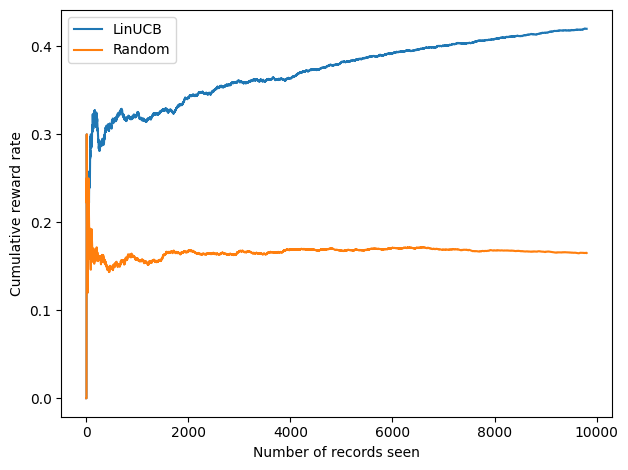

In [16]:
def get_mean_reward(rewards):
    return np.cumsum(rewards) / np.arange(1, len(rewards)+1)

fig, ax = plt.subplots()
df = pd.DataFrame({
    'LinUCB': get_mean_reward(results['bandit']['rewards']),
    'Random': get_mean_reward(results['random']['rewards']),
})
df.plot(ax=ax)
ax.set_xlabel('Number of records seen')
ax.set_ylabel('Cumulative reward rate')
plt.tight_layout()
plt.show()